In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn.init as init
from torch.distributions import Categorical
import numpy as np
from tqdm.notebook import tqdm, trange
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

from model.CustomDataSet import CustomDataSetRNN, SimpleDataSet
from model.Tokenizer import SimpleTokenizerV1
from model.OneHot import OneHot
from model.TokenDrop import TokenDrop, TokenDropOdd, TokenDropEven, TokenDropOddWithOH
# from model.Transformers import Transformer
from environnement.gridWorld import gridWorld
from outil import *

In [2]:
device = "cpu" if not torch.cuda.is_available() else "cuda"
# device = "cpu" # Pour forcer l'utilisation du CPU

In [3]:
x = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8])
y = torch.tensor([8, 7, 6, 5, 4, 3, 2, 1])

tmp_emb = torch.nn.Embedding(10, 1)
z = tmp_emb(x)

print(x + y)
print(z)
print(x.unsqueeze(1))
print(z + x.unsqueeze(1))


bernoulli_samples = torch.bernoulli(torch.ones_like(x) * 0.25)
mask = bernoulli_samples.byte()
# print(mask, x[mask])
# # Replace the masked elements with 0
# x = x.masked_fill(mask.bool(), -1)
# print(x)

tensor([9, 9, 9, 9, 9, 9, 9, 9])
tensor([[ 0.8961],
        [ 0.4232],
        [ 0.3659],
        [-0.9094],
        [ 0.2233],
        [ 0.9847],
        [ 0.7756],
        [-0.3045]], grad_fn=<EmbeddingBackward0>)
tensor([[1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8]])
tensor([[1.8961],
        [2.4232],
        [3.3659],
        [3.0906],
        [5.2233],
        [6.9847],
        [7.7756],
        [7.6955]], grad_fn=<AddBackward0>)


In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads,
                 qkv_bias = False, device = 'cpu'):
        
        super().__init__()
        assert(d_out % num_heads == 0), "d_out should be divisible by num_heads"
        
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias).to(device)

        self.dropout = nn.Dropout(dropout).to(device)
        self.out_proj = nn.Linear(d_out, d_out).to(device)
        # If we want to see only past
        mask = torch.triu(torch.ones(context_length,context_length), diagonal=1).to(device)
        
        # if we want to see only future
        # mask = torch.tril(torch.ones(context_length,context_length), diagonal=-1).to(device)
        
        # If we want to see all the context
        # mask = torch.zeros(context_length, context_length, device=device)
        self.register_buffer('mask', mask)
        
    def forward(self,x: torch.Tensor):
        queries: torch.Tensor
        keys: torch.Tensor
        values: torch.Tensor
        b, num_tokens, d_in = x.shape # b, num_token, d_in

        # self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        # self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        # self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        # Use one projection to get queries, keys and values
        # self.W_qkv(x) -> b, num_token, 3*d_out (is a tensor)
        # chunk(3, dim=-1) -> b, num_token, d_out we split the tensor in 3 parts
        queries, keys, values= self.W_qkv(x).chunk(3, dim=-1)
        
        # b, num_token, numheads, head_dim
        queries = queries.reshape(b,
                                num_tokens,
                                self.num_heads,
                                self.head_dim
                            ).transpose(1, 2)
        keys = keys.reshape(b,
                            num_tokens,
                            self.num_heads,
                            self.head_dim
                        ).transpose(1, 2)
        values = values.reshape(b,
                                num_tokens,
                                self.num_heads,
                                self.head_dim
                            ).transpose(1, 2)
        
        # b, num_heads, num_token, num_token
        attn_scores = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)
        
        attn_scores = attn_scores.masked_fill(
            self.mask[:num_tokens, :num_tokens].unsqueeze(0).unsqueeze(0).bool() == 1, 
            float('-inf')
        )

        attn_weights = nn.functional.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context = torch.einsum('bhqk, bhkd -> bhqd', 
                               attn_weights, 
                               values
                            ).transpose(1, 2).reshape(b, num_tokens, self.d_out)
        
        return self.out_proj(context)
    
class FeedForward(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        # TODO fct FFN we can remove or add some layers
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], cfg["emb_dim"] // 2, bias=cfg["qkv_bias"]),
            nn.GELU(),
            nn.Linear(cfg["emb_dim"] // 2, cfg["emb_dim"], bias=cfg["qkv_bias"])
        )
        
    def forward(self,x):
        return self.layers(x)
    

class TransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.norm1 = nn.LayerNorm(cfg["emb_dim"]).to(cfg["device"])
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length = cfg["context_length"],
            dropout = cfg["drop_rate"],
            num_heads = cfg["n_heads"],
            qkv_bias = cfg["qkv_bias"],
            device=cfg["device"]
        )
        self.ff = FeedForward(cfg).to(cfg["device"])
        self.norm2 = nn.LayerNorm(cfg["emb_dim"]).to(cfg["device"])
        self.dropout = nn.Dropout(cfg["drop_rate"]).to(cfg["device"])
        
    def forward(self,x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)

        x = self.dropout(x)

        x = x + shortcut
        
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.dropout(x)
        x = x + shortcut
        
        return x

class Transformer(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"]).to(cfg["device"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"]).to(cfg["device"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"]).to(cfg["device"])
        
        self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.norm = nn.LayerNorm(cfg["emb_dim"]).to(cfg["device"])
        
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["out_vocab_size"], bias=False).to(cfg["device"])
        self.tok_emb.weight = self.out_head.weight
        
        # self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        
        # Special initialization for transformer projection layers
        # for pn, p in self.named_parameters():
        #     if pn.endswith('c_proj.weight'):
        #         # torch.nn.init.normal_(p,
        #         #                     mean=0.0,
        #         #                     std=0.02 / math.sqrt(2 * self.cfg["n_layers"]))
        
    def forward(self,x):
        b, seq_len = x.shape
        device = x.device
        x = x + 1 # TODO remove this
        tok_embeds = self.tok_emb(x)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.norm(x)
        logits = self.out_head(x)
        return logits
    
class TrfsWithoutEmb(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        
        # self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"]).to(cfg["device"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"]).to(cfg["device"])
        # self.drop_emb = nn.Dropout(cfg["drop_rate"]).to(cfg["device"])
        
        self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.norm = nn.LayerNorm(cfg["emb_dim"]).to(cfg["device"])
        
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["out_vocab_size"], bias=False).to(cfg["device"])
        # self.tok_emb.weight = self.out_head.weight
        
        # self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        
        # Special initialization for transformer projection layers
        # for pn, p in self.named_parameters():
        #     if pn.endswith('c_proj.weight'):
        #         # torch.nn.init.normal_(p,
        #         #                     mean=0.0,
        #         #                     std=0.02 / math.sqrt(2 * self.cfg["n_layers"]))
        
    def forward(self,x: torch.Tensor, bool_test: bool = False):
        b, seq_len = x.shape
        device = x.device
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=device))
        x = x.unsqueeze(-1)
        if bool_test:
            print("shape pos_embeds", pos_embeds.shape)
            print("pos_embeds", pos_embeds)
            print("shape x", x.shape)
            print("x", x)
            # save x in log.txt
            with open("log.txt", "a") as f:
                f.write(f"x start: {x}\n")
                f.write(f"pos_embeds: {pos_embeds}\n")
            
        # x = tok_embeds + pos_embeds
        x = x + pos_embeds
        if bool_test:
            print("shape x", x.shape)
            print("x", x)
            # save x in log.txt
            with open("log.txt", "a") as f:
                f.write(f"x after add: {x}\n")
        x = self.trf_blocks(x)
        if bool_test:
            print("shape x", x.shape)
            print("x", x)
            # save x in log.txt
            with open("log.txt", "a") as f:
                f.write(f"x after trf_blocks: {x}\n")
        x = self.norm(x)
        logits = self.out_head(x)
        return logits

In [5]:
class encoder():
    """Encoder only for environment gridWorld
    """
    def __init__(self):
        self.onehot = OneHot([
            "forward",
            "feel_front",
            "feel_left",
            "feel_right",
            "turn_left",
            "turn_right",
        ])
        self.int_to_outcome = {0: "empty", 1:"wall", -1:"mask"}
        self.outcome_to_int = {"empty":0,"wall":1, "mask":-1}
        
                
    def encode(self, x):
        action = x[::2]
        outcomes = x[1::2]
        action_encoded = self.onehot.encode(action)
        outcome_encoded = [self.outcome_to_int[outcome] for outcome in outcomes]
        encoded = []
        for i in range(len(outcome_encoded)):
            encoded.extend(action_encoded[i*6:(i + 1)*6])
            encoded.append(outcome_encoded[i])
        return encoded
    
    def decode(self, x):
        res = []
        for i in range(0, len(x), self.onehot.length + 1):
            action_encoded = x[i:i + self.onehot.length]
            outcome_encoded = x[i + len(self.onehot.categories)]
            action_decoded = self.onehot.decode(action_encoded)[0]
            outcome_decoded = self.int_to_outcome[outcome_encoded]
            res.append(action_decoded)
            res.append(outcome_decoded)
        return res

In [6]:
env_encoder = encoder()
tmp = env_encoder.encode(["forward", "wall", "feel_front", "wall", "forward", "mask"])
print(tmp)
print(env_encoder.decode(tmp))

[1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, -1]
['forward', 'wall', 'feel_front', 'wall', 'forward', 'mask']


In [7]:
[1, 0, 0, 0, 0, 0, -1, 0, 1, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0,]

[1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, -1]

[1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, -1]

In [8]:
# class SimpleTransformer(nn.Module):
#     def __init__(self, vocab_size=12, d_model=32, nhead=4, num_layers=2, max_length=10):
#         super(SimpleTransformer, self).__init__()
#         self.token_emb = nn.Embedding(vocab_size, d_model)
#         self.pos_emb = nn.Embedding(max_length, d_model)
#         # encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
#         encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
#         self.fc_out = nn.Linear(d_model, vocab_size)
#         self.max_length = max_length

#     def forward(self, x):
#         batch_size, seq_len = x.size()
#         positions = torch.arange(0, seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
#         x = self.token_emb(x) + self.pos_emb(positions)
#         x = x.permute(1, 0, 2)
#         out = self.transformer_encoder(x)
#         out = out.permute(1, 0, 2)
#         out = self.transformer_encoder(x)
#         logits = self.fc_out(out)
#         return logits
    


# Data

In [9]:
def get_data(env:env, encoder:SimpleTokenizerV1|OneHot, n_episodes:int=1000):
    """
    Generate data from the environment.
    """
    data = []
    all_action:list = env.get_actions()
    for _ in range(n_episodes):
        action = np.random.choice(all_action)
        feedback = env.outcome(action)
        data += encoder.encode([action, feedback])
    return data

def get_data_without(env:env, tokenizer:SimpleTokenizerV1, acts:list[str] , n_episodes:int=1000):
    """
    Generate data from the environment.
    """
    data = []
    all_action:list = env.get_actions()
    all_action = [element for element in all_action if element not in acts]
    for _ in range(n_episodes):
        action = np.random.choice(all_action)
        feedback = env.outcome(action)
        data += tokenizer.encode([action, feedback])
    return data

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 1 0 1]
 [1 0 1 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]


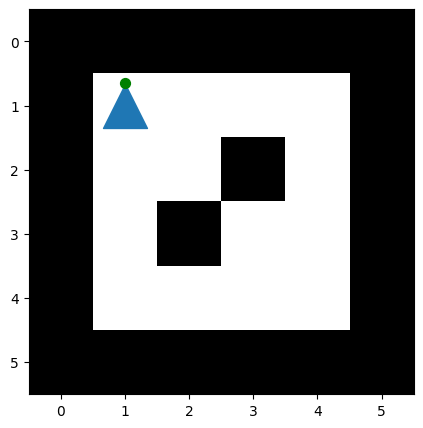

In [10]:
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 1, 0, 1],
                [1, 0, 1, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))
actions, outcomes = [], []
env_test.display_world()

# Tokenizer or One Hot

In [11]:
list_vocab = ['<pad>']
for act in env_test.get_actions():
    list_vocab.append(act)
for fb in env_test.get_outcomes():
    list_vocab.append(fb)    
tmp = create_dico_numerate_word(list_vocab)
tokenizer = SimpleTokenizerV1(vocab=tmp)
one_hot = OneHot(list_vocab)
for key, value in tokenizer.int_to_str.items():
    print(f"{tokenizer.encode(value)} | {one_hot.encode(value)} => {value}")
    

0 | [1, 0, 0, 0, 0, 0, 0, 0, 0] => <pad>
1 | [0, 1, 0, 0, 0, 0, 0, 0, 0] => forward
2 | [0, 0, 1, 0, 0, 0, 0, 0, 0] => turn_left
3 | [0, 0, 0, 1, 0, 0, 0, 0, 0] => turn_right
4 | [0, 0, 0, 0, 1, 0, 0, 0, 0] => feel_front
5 | [0, 0, 0, 0, 0, 1, 0, 0, 0] => feel_left
6 | [0, 0, 0, 0, 0, 0, 1, 0, 0] => feel_right
7 | [0, 0, 0, 0, 0, 0, 0, 1, 0] => wall
8 | [0, 0, 0, 0, 0, 0, 0, 0, 1] => empty


# X and Y

## Chaque séquence est complètement indépendante

In [12]:
data_brut_y=[]
data_brut_y_one_hot=[]
nb_act = 20

context_length_tokenizer = nb_act * 2
context_length_one_hot = (nb_act * len(one_hot.categories)) * 2

for i in range(1000):
    data_brut_y.append(get_data(env_test, tokenizer, n_episodes=nb_act))
    data_brut_y_one_hot.append(get_data(env_test, one_hot, n_episodes=nb_act))

data_y_tok = torch.tensor(data_brut_y)
data_loader_tok = DataLoader(data_y_tok, batch_size=16, shuffle=True)
data_y_oh = torch.tensor(data_brut_y_one_hot)
data_loader_oh = DataLoader(data_y_oh, batch_size=16, shuffle=True)


## Une grande séquence découper

In [13]:
# data_brut = get_data(env_test, tokenizer, n_episodes=1000)
# print(data_brut)
# def decoup_seq(seq:list, size:int, overlap:int=1):
#     """
#     Decoupe une sequence en sous-sequence de taille size
#     """
#     return [seq[i:i+size] for i in range(0, len(seq) - size +1, overlap)]

# data_decoup = decoup_seq(seq=data_brut, size=30, overlap=10)
# print(data_decoup)
# data_decoup = torch.tensor(data_decoup)
# data_loader_decoup = DataLoader(data_decoup, batch_size=1, shuffle=True)

data_y est alors notre Y. Pour obtenir notre X, nous utiliserons un token Dropen

Notre x est donc data_x. Maintenant nous voulons que notre model arrive à obvenir un représentation de la séquence pour réussir a compléter les 0.

In [14]:
def train(model, data_loader, optimizer, loss_fn, epoch, td: TokenDropOdd, device):
    list_loss = []
    list_loss_all = []
    list_acc = []
    list_acc_all = []
    model.train()
    for e in tqdm(range(epoch), desc="Epoch"):
        total_loss = 0
        batch_bar = tqdm(data_loader, desc="Batch")
        for i, y in enumerate(batch_bar):
            x = td(y)
            x = x.to(device)
            y = y.to(device)
            # print("x", x)
            # print("x", x.shape)
            # print("y", y)
            # print("y", y.shape)
            # for element in x:
            #     print("element", one_hot.decode(element.tolist()))
            # raise ValueError("end")
            logits = model(x)

            optimizer.zero_grad()
            loss = loss_fn(logits.flatten(0, 1), y.flatten())
            if e == 15 or e == 2: 
                for log, tmp_y in zip(logits, y):
                    print("logits", log)
                    print("arg max ", log.argmax(-1))
                    print("y", tmp_y)
            # raise ValueError("end")
            # acc = (logits.argmax(-1) == y).float().sum()
            list_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            
            # batch_bar.set_postfix(loss=loss.item(), acc=acc.item())
            # batch_bar.set_description(f"Epoch {e+1}/{epoch} - Batch {i+1}/{len(data_loader)}")
            # batch_bar.set_postfix(loss=loss.item(), acc=acc.item())
            # batch_bar.update(1)
            # if i % 10 == 0:
            #     print(f"Epoch {e+1}/{epoch} - Batch {i+1}/{len(data_loader)} - Loss: {loss.item()} - Acc: {acc.item()}")
        if e == 15 or e == 2: 
            print("logits", logits.shape)
            print("y", y.shape)
            print("logits", logits[-1])
            print("y", y[-1])
            print("x", x[-1])
            print("arg max ", logits[-1].argmax(-1))
            print("loss ", loss.item())
                
        
        batch_bar.clear()
        batch_bar.close()
        
        train_loss = total_loss / len(data_loader.dataset)
        list_loss_all.append(train_loss)
        correct = (logits.argmax(-1) == y).float().sum()
        acc = correct / (y.shape[0] * y.shape[1])
        list_acc_all.append(acc.item())

    return list_loss_all, list_loss, list_acc_all


In [15]:
# transformer_model = SimpleTransformer(
#     vocab_size=len(tokenizer.int_to_str),
#     d_model=32 * 8,
#     nhead=4,
#     num_layers=4,
#     max_length=context_length_one_hot
# ).to(device)
# loss_fn = nn.CrossEntropyLoss().to(device)
# optimizer = optim.AdamW(transformer_model.parameters())

In [16]:
cfg = {
    "vocab_size": 3,
    "out_vocab_size": 3,
    "emb_dim": 32 * 4,
    "context_length": context_length_one_hot,
    "n_heads": 1,
    "n_layers": 2,
    "drop_rate": 0.2,
    "qkv_bias": False,
    "device": device
}

transformer_model = Transformer(cfg).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(transformer_model.parameters())

In [22]:
cfg = {
    "vocab_size": 3,
    "out_vocab_size": 3,
    "emb_dim": 32 * 4,
    "context_length": context_length_one_hot,
    "n_heads": 1,
    "n_layers": 1,
    "drop_rate": 0.2,
    "qkv_bias": False,
    "device": device
}

transformer_model = TrfsWithoutEmb(cfg).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
# loss_fn = nn.MSELoss().to(device)
optimizer = optim.AdamW(transformer_model.parameters())

In [23]:

td = TokenDropOddWithOH(
    oh=one_hot,
    mask_token=-1,
    prob=0.25
)
loss, all_loss, all_acc = train(
    model=transformer_model,
    data_loader=data_loader_oh,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epoch=20,
    td=td,
    device=device
)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Batch:   0%|          | 0/63 [00:00<?, ?it/s]

logits tensor([[ 3.6534, -0.0533, -6.5682],
        [ 2.7533,  0.8103, -4.1594],
        [ 0.7129, -0.8570, -2.8297],
        ...,
        [ 3.8324, -1.8931, -4.4070],
        [ 1.8982,  0.7241, -4.4703],
        [ 0.0776, -0.0390, -1.8913]], device='cuda:0',
       grad_fn=<UnbindBackward0>)
arg max  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Batch:   0%|          | 0/63 [00:00<?, ?it/s]

logits tensor([[ 4.7989, -1.7941, -6.7730],
        [ 3.2526,  1.7421, -7.6535],
        [ 3.3995,  1.7118, -9.3622],
        ...,
        [ 6.3492, -3.8883, -5.5817],
        [ 3.2108,  2.1802, -8.9678],
        [ 1.7843,  2.5012, -6.9390]], device='cuda:0',
       grad_fn=<UnbindBackward0>)
arg max  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Batch:   0%|          | 0/63 [00:00<?, ?it/s]

loss [0.022903717637062074, 0.015273048534989358, 0.014566077336668969, 0.014324687212705613, 0.014208616137504577, 0.014152690261602402, 0.014121181532740593, 0.014085915818810463, 0.014069031506776809, 0.014047203183174133, 0.014038374990224839, 0.014026536792516708, 0.014013443425297737, 0.014000890433788299, 0.013990496888756752, 0.013984395682811738, 0.01398493118584156, 0.013980880603194237, 0.013970136538147927, 0.013969146490097046]
all_loss [1.1764426231384277, 1.0430347919464111, 0.9181599020957947, 0.8187819719314575, 0.7102301120758057, 0.6218312382698059, 0.5516817569732666, 0.4971429109573364, 0.44958192110061646, 0.4320714771747589, 0.41231122612953186, 0.4051200747489929, 0.39556482434272766, 0.3882168233394623, 0.38274627923965454, 0.37437698245048523, 0.36430367827415466, 0.35216861963272095, 0.34234318137168884, 0.330335795879364, 0.3233121931552887, 0.3109417259693146, 0.3187023103237152, 0.31201937794685364, 0.3078988492488861, 0.3016493022441864, 0.295077323913574

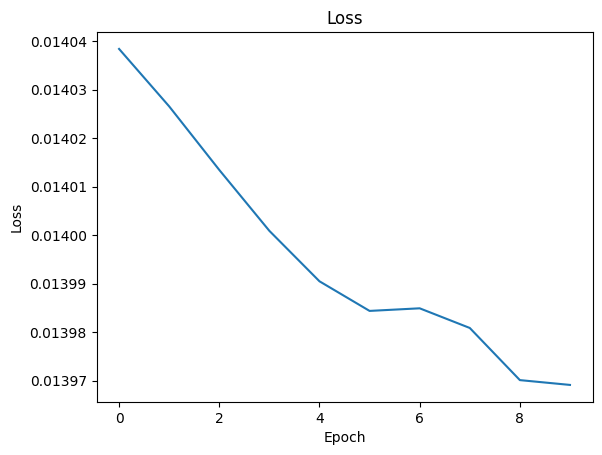

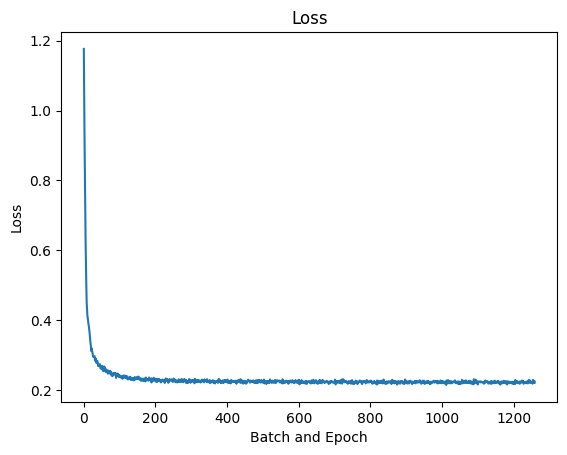

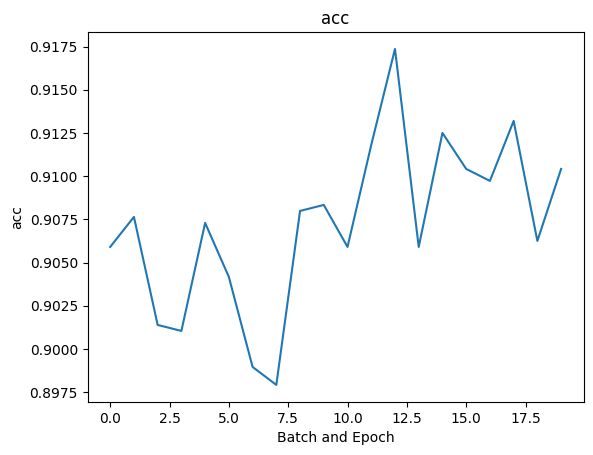

In [24]:
print("loss", loss)
print("all_loss", all_loss)

# plot
plt.plot(loss[-10:])
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.plot(all_loss)
plt.title("Loss")
plt.xlabel("Batch and Epoch")
plt.ylabel("Loss")
plt.show()


plt.plot(all_acc)
plt.title("acc")
plt.xlabel("Batch and Epoch")
plt.ylabel("acc")
plt.show()

In [20]:
transformer_model.eval()
prompt = one_hot.encode(
['feel_front', 'wall', 'turn_right', 'empty', 'turn_right', 'empty', 'feel_front', 'empty', 'turn_right', 'empty', 'feel_front', 'wall', 'turn_right', 'empty', 'turn_right', 'empty', 'turn_right', 'empty', 'feel_front']
)

prompt += [-1] * one_hot.length 
prompt_tensor = torch.tensor(prompt).to(device)
prompt_tensor = prompt_tensor.unsqueeze(0)
logits = transformer_model(prompt_tensor)
pred = logits.argmax(-1)
proba = logits.softmax(-1)

print(one_hot.decode(prompt_tensor[0].tolist()))
print("prot : ", prompt_tensor[0].tolist())
print("pred : ", pred[0].tolist())
print(one_hot.decode(pred[0].tolist()))
print("proba for last token", torch.round(F.softmax(proba[0, -1, :], dim=0) * 1000) / 1000)

prompt = one_hot.encode(
['feel_front', 'wall', 'turn_right', 'empty', 'turn_right', 'empty', 'feel_front', 'empty', 'turn_right', 'empty', 'feel_front', 'wall', 'turn_right', 'empty', 'turn_right', 'empty', 'turn_right', 'empty', 'feel_right', 'wall', 'feel_right']
)

prompt += [-1] * one_hot.length 
prompt_tensor = torch.tensor(prompt).to(device)
prompt_tensor = prompt_tensor.unsqueeze(0)
logits = transformer_model(prompt_tensor)
pred = logits.argmax(-1)
proba = logits.softmax(-1)

print(one_hot.decode(prompt_tensor[0].tolist()))
print(one_hot.decode(pred[0].tolist()))
print("proba for last token", torch.round(F.softmax(proba[0, -1, :], dim=0) * 1000) / 1000)

prompt = one_hot.encode(
['feel_front', 'wall', 'turn_right', 'empty', 'turn_right', 'empty', 'feel_front', 'empty', 'turn_right', 'empty', 'feel_front', 'wall', 'turn_right', 'empty', 'turn_right', 'empty', 'turn_right', 'empty', 'feel_left']
)

prompt += [-1] * one_hot.length 
prompt_tensor = torch.tensor(prompt).to(device)
prompt_tensor = prompt_tensor.unsqueeze(0)
logits = transformer_model(prompt_tensor)
pred = logits.argmax(-1)
proba = logits.softmax(-1)

print(one_hot.decode(prompt_tensor[0].tolist()))
print(one_hot.decode(pred[0].tolist()))
print("proba for last token", torch.round(F.softmax(proba[0, -1, :], dim=0) * 1000) / 1000)




['feel_front', 'wall', 'turn_right', 'empty', 'turn_right', 'empty', 'feel_front', 'empty', 'turn_right', 'empty', 'feel_front', 'wall', 'turn_right', 'empty', 'turn_right', 'empty', 'turn_right', 'empty', 'feel_front', '<mask>']
prot :  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1]
pred :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [21]:
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 1, 0, 1],
                [1, 0, 1, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

data_test_x = []
data_test_y = []
data_infos = []
for i in range(10000):
    # range_context = np.random.randint(10, 20)
    range_context = nb_act
    last_act = "turn_left"
    while last_act == "turn_left" or last_act == "turn_right":
        sequence = get_data(env_test, tokenizer, n_episodes=range_context)
        last_act = tokenizer.decode(sequence[-2])
            
    data_test_x.append(sequence[:-1] + [tokenizer.encode("<mask>")])    
    data_test_y.append(sequence[-1])
    
    data_infos.append({
        "sequence": sequence,
        "coo": env_test.get_coo(),
        "theta": env_test.get_theta(),
        "last_act": last_act,
        "last_feedback": tokenizer.decode(sequence[-1]),
        "info_in_sequence": bool(info_in_seq(tokenizer.decode(data_test_x[-1]), 6))
    })
    around = ''
    for feel in ["feel_front", "feel_left", "feel_right"]:
        state = env_test.outcome(feel)
        data_infos[-1][feel] = state
        around += f"{state}|"
    
# print("data_test_x", data_test_x)
# print("data_test_y", data_test_y)

# count 9 and 8 in data_test_y
count_7 = 0
count_8 = 0

for i in data_test_y:
    if i == 8:
        count_8 += 1
    elif i == 7:
        count_7 += 1
print(f"count_8 {tokenizer.decode(8)}", count_8)
print(f"count_7 {tokenizer.decode(7)}", count_7)

print("data_infos", data_infos[0])
print("x ", data_test_x[0])
print("y ", data_test_y[0])

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 1 0 1]
 [1 0 1 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]


KeyError: '<mask>'

In [ ]:
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 1, 0, 1],
                [1, 0, 1, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

data_test_x = []
data_test_y = []
data_infos = []
for i in range(10000):
    # range_context = np.random.randint(10, 20)
    range_context = nb_act
    last_act = "turn_left"
    while last_act == "turn_left" or last_act == "turn_right":
        sequence = get_data(env_test, one_hot, n_episodes=range_context)
        last_act = one_hot.decode(sequence[-2 * len(one_hot.categories) : -len(one_hot.categories)])
            
    data_test_x.append(sequence[:-len(one_hot.categories)] + one_hot.encode("<pad>"))    
    data_test_y.append(sequence[-len(one_hot.categories):])
    
    data_infos.append({
        "sequence": sequence,
        "coo": env_test.get_coo(),
        "theta": env_test.get_theta(),
        "last_act": last_act,
        "last_feedback": one_hot.decode(sequence[-len(one_hot.categories):]),
        "info_in_sequence": bool(info_in_seq(one_hot.decode(data_test_x[-1]), 6))
    })
    # around = ''
    # for feel in ["feel_front", "feel_left", "feel_right"]:
    #     state = env_test.outcome(feel)
    #     data_infos[-1][feel] = state
    #     around += f"{state}|"
    

print("data_infos", data_infos[0])
print("x ", data_test_x[0])
print("y ", data_test_y[0])

In [ ]:
for key, value in data_infos[56].items():
    print(f"{key}: {value}")


In [ ]:
length = max(len(xi) for xi in data_test_x)
data_test_x_tensor = torch.zeros((len(data_test_x), length), dtype=torch.long)
for i, xi in enumerate(data_test_x):
    data_test_x_tensor[i, :len(xi)] = torch.tensor(xi, dtype=torch.long)
data_test_y_tensor = torch.tensor(data_test_y, dtype=torch.long)

class CustomDataset(Dataset):
    def __init__(self, data:torch.Tensor, targets:torch.Tensor, data_infos):
        self.data = data
        self.targets = targets
        self.infos = data_infos

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]
        info = self.infos[idx]
        return sample, target, info

data_loader_test = DataLoader(CustomDataset(data_test_x_tensor, data_test_y_tensor, data_infos), batch_size=1, shuffle=False)

for i, (data_x, data_y, info) in enumerate(data_loader_test):
    print(data_x)
    print(data_y)
    print(info)
    break

In [ ]:
# One Hot Encode
transformer_model.eval()
acc = 0

data_frame_seq = pd.DataFrame({
    "seq": [""] * len(data_loader_test),
    "seq_dec": [""] * len(data_loader_test),
    "prediction": [""] * len(data_loader_test),
    "prediction_dec": [""] * len(data_loader_test),
    "reality": [""] * len(data_loader_test),
    "reality_dec": [""] * len(data_loader_test),
    "probability": [""] * len(data_loader_test),
    "good_prediction": [False] * len(data_loader_test),
    "info_in_seq": [False] * len(data_loader_test),
    "info_feel_left": [False] * len(data_loader_test),
    "info_feel_front": [False] * len(data_loader_test),
    "info_feel_right": [False] * len(data_loader_test),
    "coo_xy": [""] * len(data_loader_test),
    "theta": [-1] * len(data_loader_test),
    "state_left": [""] * len(data_loader_test),
    "state_front": [""] * len(data_loader_test),
    "state_right": [""] * len(data_loader_test),
    
})

# data_frame_seq = data_frame_seq.astype({
#     "seq": "object",
#     "prediction": "U20",
#     "reality": "object",
#     "probability": "object",
#     "good_prediction": "bool",
#     "info_in_seq": "bool",
#     "info_feel_left": "bool",
#     "info_feel_front": "bool",
#     "info_feel_right": "bool",
#     "coo_xy": "object",
#     "theta": "int64"
# })

with torch.no_grad():
    for i, (input, target, info) in tqdm(enumerate(data_loader_test)):
        input = input.to(device)
        target:torch.Tensor = target.to(device)
        output = transformer_model(input)
        print("shape output", output.shape)
        print("shape input", input.shape)
        
        arrays, x, y, theta = process_sequence(one_hot.decode(input.tolist()[0]), 6, None)
        good_seq = info_in_memory(arrays)
        feel_left, feel_front, feel_right = feel_info_end_sequence(one_hot.decode(input.tolist()[0]), 6, (arrays, x, y, theta))
        
        proba = F.softmax(output, dim=-1)
        output = output.transpose(1, 2)
        pred = output.argmax(dim=1)
        print("shape pred", pred.shape)
        print("shape proba", proba.shape)
        # print(input[-1])
        print(pred[-1][-9:])
        
        acc += (pred[-1][-9:] == target)
        state_left = info["feel_left"][0]
        state_front = info["feel_front"][0]
        state_right = info["feel_right"][0]
        coo = (info["coo"][0].item(), info["coo"][1].item())
        theta = info["theta"][0].item()

        data_frame_seq.loc[i] = [
            str(input.tolist()[0]),
            str(one_hot.decode(input.tolist()[0])),
            str(pred.tolist()[0][-1]),
            str(one_hot.decode(pred.tolist()[0][-1])),
            target.tolist()[0],
            one_hot.decode(target.tolist()[0]),
            str(proba.tolist()[-1][-1][-2:]),
            (pred[-1][-1] == target).item(),
            good_seq,
            feel_left,
            feel_front,
            feel_right,
            str(coo),
            theta,
            state_left,
            state_front,
            state_right
        ]
print(f"Accuracy: {acc / 10000}")

In [ ]:
# Tokenizer
transformer_model.eval()
acc = 0

data_frame_seq = pd.DataFrame({
    "seq": [""] * len(data_loader_test),
    "seq_dec": [""] * len(data_loader_test),
    "prediction": [""] * len(data_loader_test),
    "prediction_dec": [""] * len(data_loader_test),
    "reality": [""] * len(data_loader_test),
    "reality_dec": [""] * len(data_loader_test),
    "probability": [""] * len(data_loader_test),
    "good_prediction": [False] * len(data_loader_test),
    "info_in_seq": [False] * len(data_loader_test),
    "info_feel_left": [False] * len(data_loader_test),
    "info_feel_front": [False] * len(data_loader_test),
    "info_feel_right": [False] * len(data_loader_test),
    "coo_xy": [""] * len(data_loader_test),
    "theta": [-1] * len(data_loader_test),
    "state_left": [""] * len(data_loader_test),
    "state_front": [""] * len(data_loader_test),
    "state_right": [""] * len(data_loader_test),
    
})

# data_frame_seq = data_frame_seq.astype({
#     "seq": "object",
#     "prediction": "U20",
#     "reality": "object",
#     "probability": "object",
#     "good_prediction": "bool",
#     "info_in_seq": "bool",
#     "info_feel_left": "bool",
#     "info_feel_front": "bool",
#     "info_feel_right": "bool",
#     "coo_xy": "object",
#     "theta": "int64"
# })

with torch.no_grad():
    for i, (input, target, info) in tqdm(enumerate(data_loader_test)):
        input = input.to(device)
        target = target.to(device)
        output = transformer_model(input)
        
        arrays, x, y, theta = process_sequence(tokenizer.decode(input.tolist()[0]), 6, None)
        good_seq = info_in_memory(arrays)
        feel_left, feel_front, feel_right = feel_info_end_sequence(tokenizer.decode(input.tolist()[0]), 6, (arrays, x, y, theta))
        
        proba = F.softmax(output, dim=-1)
        output = output.transpose(1, 2)
        pred = output.argmax(dim=1)
        acc += (pred[-1][-1] == target).item()
        state_left = info["feel_left"][0]
        state_front = info["feel_front"][0]
        state_right = info["feel_right"][0]
        coo = (info["coo"][0].item(), info["coo"][1].item())
        theta = info["theta"][0].item()

        data_frame_seq.loc[i] = [
            str(input.tolist()[0]),
            str(tokenizer.decode(input.tolist()[0])),
            str(pred.tolist()[0][-1]),
            str(tokenizer.decode(pred.tolist()[0][-1])),
            target.tolist()[0],
            tokenizer.decode(target.tolist()[0]),
            str(proba.tolist()[-1][-1][-2:]),
            (pred[-1][-1] == target).item(),
            good_seq,
            feel_left,
            feel_front,
            feel_right,
            str(coo),
            theta,
            state_left,
            state_front,
            state_right
        ]
print(f"Accuracy: {acc / 10000}")

In [ ]:
# keep only row with good_prediction = True
data_frame_seq_success = data_frame_seq.loc[data_frame_seq["good_prediction"]]

In [ ]:
end

# Résultat

0.50 % d'accuracy  



# Embeding

In [ ]:
model_fb.eval()
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size).to(device)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size).to(device)
print("hidden_in", hidden_in.shape)
print("mem_in", mem_in.shape)
all_hidden = []
all_mem = []
all_output_1 = []
all_output_2 = []

# for x, y, info in zip(data_test_x, data_test_y, data_infos):
#     input_seq = torch.tensor(x).to(device)
#     output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))
#     all_hidden.append(hidden_out[-1])
#     all_mem.append(mem_out[-1])
#     all_output_1.append(output[-1])
#     all_output_2.append(output[29])

# keep only data_frame_seq(data frame) with feel_left, feel_front, feel_right
data_infos_success = data_frame_seq.loc[
    # (data_frame_seq["info_feel_left"]) & 
    # (data_frame_seq["info_feel_front"]) & 
    # (data_frame_seq["info_feel_right"]) &
    # (data_frame_seq["good_prediction"])
    (data_frame_seq["info_in_seq"])
]
print("data_infos_success", len(data_infos_success))

# data_infos_sucess = [d for d in data_infos if all(d["feel_left", "feel_front", "feel_right"])]
for sequence in data_infos_success["seq"]:
    sequence = eval(sequence)
    input_seq = torch.tensor(sequence).to(device)
    output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))
    all_hidden.append(hidden_out[-1])
    all_mem.append(mem_out[-1])
    all_output_1.append(output[-1])
    all_output_2.append(output[-3])


# print("shape output", all_output_1[0].shape)

In [ ]:
print(tokenizer.encode(["feel_front", "feel_left", "feel_right"]))

In [ ]:
import seaborn as sns
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
all_hidden_stack = torch.stack(all_hidden)
all_mem_stack = torch.stack(all_mem)
all_hidden_stack = all_hidden_stack.detach().cpu().numpy()
all_mem_stack = all_mem_stack.detach().cpu().numpy()
all_hidden_emb = tsne.fit_transform(all_hidden_stack)
all_mem_emb = tsne.fit_transform(all_mem_stack)

coo_info = data_infos_success["coo_xy"].tolist()

unique_coo = np.unique(coo_info)
color_map = plt.cm.get_cmap('viridis', len(unique_coo))
coo_colors = [color_map(unique_coo.tolist().index(str(coo))) for coo in coo_info]

theta_info = data_infos_success["theta"].tolist()

unique_theta = np.unique(theta_info)
# Attribuer une former pour chaque valeur unique de theta
markers_list = ['o', 's', 'D', 'v', '^', '<', '>', 'P', 'X', '*']
markers_map = {theta: markers_list[i % len(markers_list)] for i, theta in enumerate(unique_theta)}
theta_markers = [markers_map[theta] for theta in theta_info]


plt.figure(figsize=(12, 6))

# Plot pour all_hidden_emb
plt.subplot(1, 2, 1)
plt.scatter(all_hidden_emb[:, 0], all_hidden_emb[:, 1], c=coo_colors, cmap='rocket', alpha=0.6)
plt.title('t-SNE visualization of hidden states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')

# Plot pour all_mem_emb
plt.subplot(1, 2, 2)
plt.scatter(all_mem_emb[:, 0], all_mem_emb[:, 1], c=coo_colors, cmap='rocket', alpha=0.6)
plt.title('t-SNE visualization of memory states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')

# Ajouter une légende pour les couleurs
for coo, color in zip(unique_coo, color_map(np.arange(len(unique_coo)))):
    plt.scatter([], [], c=[color], label=f'coo {coo}')
plt.legend(title='coo values')

plt.tight_layout()
plt.show()
plt.close()

tsne = TSNE(n_components=2, random_state=42, perplexity=2, n_iter=300)

all_output_stack = torch.stack(all_output_1)
all_output_stack = all_output_stack.detach().cpu().numpy()
print("all_output_stack", all_output_stack.shape)
all_output_emb = tsne.fit_transform(all_output_stack)
print("all_output_emb", all_output_emb.shape)
plt.figure(figsize=(12, 6))
for i in range(len(all_output_emb)):
    plt.scatter(all_output_emb[i, 0], all_output_emb[i, 1], c=[coo_colors[i]], marker=theta_markers[i], alpha=0.6)
plt.title('t-SNE visualization of output states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for coo, color in zip(unique_coo, color_map(np.arange(len(unique_coo)))):
    plt.scatter([], [], c=[color], label=f'coo {coo}')
plt.legend(title='coo values')
plt.tight_layout()
plt.show()
plt.close()

tsne = TSNE(n_components=2, random_state=42, perplexity=2, n_iter=300)

all_output_stack = torch.stack(all_output_2)
all_output_stack = all_output_stack.detach().cpu().numpy()
print("all_output_stack", all_output_stack.shape)
all_output_emb = tsne.fit_transform(all_output_stack)
print("all_output_emb", all_output_emb.shape)
plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=coo_colors, cmap='rocket', alpha=0.6)
plt.title('t-SNE visualization of output states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for coo, color in zip(unique_coo, color_map(np.arange(len(unique_coo)))):
    plt.scatter([], [], c=[color], label=f'coo {coo}')
plt.legend(title='coo values')
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
all_hidden_stack = torch.stack(all_hidden)
all_mem_stack = torch.stack(all_mem)
print("all_hidden", all_hidden_stack.shape)
print("all_mem", all_mem_stack.shape)
all_hidden_stack = all_hidden_stack.detach().cpu().numpy()
all_mem_stack = all_mem_stack.detach().cpu().numpy()
print("all_hidden", all_hidden_stack.shape)
print("all_mem", all_mem_stack.shape)
all_hidden_emb = tsne.fit_transform(all_hidden_stack)
all_mem_emb = tsne.fit_transform(all_mem_stack)
print("all_hidden_emb", all_hidden_emb.shape)
print("all_mem_emb", all_mem_emb.shape)

feel_info = [str(info[0][0:2]) + '|' + str(info[1][0:2]) + '|' + str(info[2][0:2]) for info in zip(data_infos_success["state_left"], data_infos_success["state_front"], data_infos_success["state_right"])]

print("feel_info", feel_info)
unique_feel = np.unique(feel_info)
print("unique_feel", unique_feel)
color_map = plt.cm.get_cmap('viridis', len(unique_feel))
feel_colors = [color_map(unique_feel.tolist().index(str(feel))) for feel in feel_info]
plt.figure(figsize=(12, 6))
# Plot pour all_hidden_emb
plt.subplot(1, 2, 1)
plt.scatter(all_hidden_emb[:, 0], all_hidden_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)
plt.title('t-SNE visualization of hidden states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Plot pour all_mem_emb
plt.subplot(1, 2, 2)
plt.scatter(all_mem_emb[:, 0], all_mem_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)
plt.title('t-SNE visualization of memory states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_feel, color_map(np.arange(len(unique_feel)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='feels values (Left Front Right)')
plt.tight_layout()
plt.show()

tsne = TSNE(n_components=2, random_state=42, perplexity=2, n_iter=300)

all_output_stack = torch.stack(all_output_1)
all_output_stack = all_output_stack.detach().cpu().numpy()
print("all_output_stack", all_output_stack.shape)
all_output_emb = tsne.fit_transform(all_output_stack)
print("all_output_emb", all_output_emb.shape)
plt.figure(figsize=(12, 6))
# plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)
for i in range(len(all_output_emb)):
    plt.scatter(all_output_emb[i, 0], all_output_emb[i, 1], c=[feel_colors[i]], marker=theta_markers[i], alpha=0.6)
plt.title('t-SNE visualization of output states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_feel, color_map(np.arange(len(unique_feel)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='feels values (Left Front Right)')
plt.tight_layout()
plt.show()


tsne = TSNE(n_components=2, random_state=42, perplexity=2, n_iter=300)

all_output_stack = torch.stack(all_output_2)
all_output_stack = all_output_stack.detach().cpu().numpy()
print("all_output_stack", all_output_stack.shape)
all_output_emb = tsne.fit_transform(all_output_stack)
print("all_output_emb", all_output_emb.shape)
plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)
plt.title('t-SNE visualization of output states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_feel, color_map(np.arange(len(unique_feel)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='feels values (Left Front Right)')
plt.tight_layout()
plt.show()


In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
all_hidden_stack = torch.stack(all_hidden)
all_mem_stack = torch.stack(all_mem)
all_output_stack = torch.stack(all_output_1)

all_hidden_stack = all_hidden_stack.detach().cpu().numpy()
all_mem_stack = all_mem_stack.detach().cpu().numpy()
all_output_stack = all_output_stack.detach().cpu().numpy()

all_hidden_emb = tsne.fit_transform(all_hidden_stack)
all_mem_emb = tsne.fit_transform(all_mem_stack)
all_output_emb = tsne.fit_transform(all_output_stack)

front_info = [str(info) for info in data_infos_success["state_front"]]
left_info = [str(info) for info in data_infos_success["state_left"]]
right_info = [str(info) for info in data_infos_success["state_right"]]

act_pred = [str(eval(to_act)[-2]) + ' | ' +  pred for to_act, pred in zip(data_infos_success["seq_dec"], data_infos_success["prediction_dec"])]
act = [str(eval(to_act)[-2]) for to_act in data_infos_success["seq_dec"]]

print("act_pred", act_pred)

unique_front = np.unique(front_info)
unique_left = np.unique(left_info)
unique_right = np.unique(right_info)
unique_act_pred = np.unique(act_pred)
unique_act = np.unique(act)

color_map_front = plt.cm.get_cmap('viridis', len(unique_front))
front_colors = [color_map_front(unique_front.tolist().index(str(feel))) for feel in front_info]

color_map_left = plt.cm.get_cmap('viridis', len(unique_left))
left_colors = [color_map_left(unique_left.tolist().index(str(feel))) for feel in left_info]

color_map_right = plt.cm.get_cmap('viridis', len(unique_feel))
right_colors = [color_map_right(unique_right.tolist().index(str(feel))) for feel in right_info]

color_map_act_pred = plt.cm.get_cmap('viridis', len(unique_act_pred))
act_pred_colors = [color_map_act_pred(unique_act_pred.tolist().index(_act)) for _act in act_pred]

color_map_act = plt.cm.get_cmap('viridis', len(unique_act))
act_colors = [color_map_act(unique_act.tolist().index(_act)) for _act in act]

plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=act_pred_colors, cmap='viridis', alpha=0.6)
plt.title('t-SNE visualization of output states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for coo, color in zip(unique_act_pred, color_map_act_pred(np.arange(len(unique_act_pred)))):
    plt.scatter([], [], c=[color], label=f'{coo}')
plt.legend(title='action, prediction')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=act_colors, cmap='viridis', alpha=0.6)
plt.title('t-SNE visualization of output states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for coo, color in zip(unique_act, color_map_act(np.arange(len(unique_act)))):
    plt.scatter([], [], c=[color], label=f'{coo}')
plt.legend(title='action, prediction')
plt.tight_layout()
plt.show()

# plt.figure(figsize=(12, 6))
# plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=front_colors, cmap='viridis', alpha=0.6)
# plt.title('t-SNE visualization of output states')
# plt.xlabel('t-SNE component 1')
# plt.ylabel('t-SNE component 2')
# # Ajouter une légende pour les couleurs
# for coo, color in zip(unique_feel, color_map_front(np.arange(len(unique_feel)))):
#     plt.scatter([], [], c=[color], label=f'fb {coo}')
# plt.legend(title='feedback, front')
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(12, 6))
# plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=left_colors, cmap='viridis', alpha=0.6)
# plt.title('t-SNE visualization of output states')
# plt.xlabel('t-SNE component 1')
# plt.ylabel('t-SNE component 2')
# # Ajouter une légende pour les couleurs
# for coo, color in zip(unique_left, color_map_left(np.arange(len(unique_left)))):
#     plt.scatter([], [], c=[color], label=f'fb {coo}')
# plt.legend(title='feedback, left')
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(12, 6))
# plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=right_colors, cmap='viridis', alpha=0.6)
# plt.title('t-SNE visualization of output states')
# plt.xlabel('t-SNE component 1')
# plt.ylabel('t-SNE component 2')
# # Ajouter une légende pour les couleurs
# for coo, color in zip(unique_right, color_map_right(np.arange(len(unique_right)))):
#     plt.scatter([], [], c=[color], label=f'fb {coo}')
# plt.legend(title='feedback, right')
# plt.tight_layout()
# plt.show()

# tsne = TSNE(n_components=3, random_state=42, perplexity=2, n_iter=300)
# all_output_emb = tsne.fit_transform(all_output_stack)

# fig = plt.figure(figsize=(12, 6))
# ax1 = fig.add_subplot(121, projection='3d')
# sc1 = ax1.scatter(all_output_emb[:, 0], all_output_emb[:, 1], all_output_emb[:, 2], c=front_colors, cmap='viridis', alpha=0.6)
# ax1.set_title('t-SNE visualization of output states (all_output)')
# ax1.set_xlabel('t-SNE component 1')
# ax1.set_ylabel('t-SNE component 2')
# ax1.set_zlabel('t-SNE component 3')


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Ajuster TSNE pour générer trois composants
tsne = TSNE(n_components=3, random_state=42, perplexity=5, n_iter=300)

# Transformer les données en embeddings 3D
all_hidden_stack = torch.stack(all_hidden)
all_mem_stack = torch.stack(all_mem)
all_hidden_stack = all_hidden_stack.detach().cpu().numpy()
all_mem_stack = all_mem_stack.detach().cpu().numpy()
all_hidden_emb = tsne.fit_transform(all_hidden_stack)
all_mem_emb = tsne.fit_transform(all_mem_stack)

# Extraire les informations "feel" de data_infos

feel_info = [str(info[0]) + str(info[1]) + str(info[2]) for info in zip(data_infos_success["state_left"], data_infos_success["state_front"], data_infos_success["state_right"])]
unique_feel = np.unique(feel_info)
color_map = plt.cm.get_cmap('viridis', len(unique_feel))
feel_colors = [color_map(unique_feel.tolist().index(str(feel))) for feel in feel_info]

# Créer les scatter plots 3D pour les embeddings
fig = plt.figure(figsize=(12, 6))

# Plot pour all_hidden_emb
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(all_hidden_emb[:, 0], all_hidden_emb[:, 1], all_hidden_emb[:, 2], c=feel_colors, cmap='viridis', alpha=0.6)
ax1.set_title('t-SNE visualization of hidden states')
ax1.set_xlabel('t-SNE component 1')
ax1.set_ylabel('t-SNE component 2')
ax1.set_zlabel('t-SNE component 3')

# Plot pour all_mem_emb
ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(all_mem_emb[:, 0], all_mem_emb[:, 1], all_mem_emb[:, 2], c=feel_colors, cmap='viridis', alpha=0.6)
ax2.set_title('t-SNE visualization of memory states')
ax2.set_xlabel('t-SNE component 1')
ax2.set_ylabel('t-SNE component 2')
ax2.set_zlabel('t-SNE component 3')

# Ajouter une légende pour les couleurs
legend1 = ax1.legend(*sc1.legend_elements(), title="feel values")
ax1.add_artist(legend1)
legend2 = ax2.legend(*sc2.legend_elements(), title="feel values")
ax2.add_artist(legend2)

plt.tight_layout()
plt.show()

# Pour les sorties all_output_1 et all_output_2
tsne = TSNE(n_components=3, random_state=42, perplexity=2, n_iter=300)

all_output_stack_1 = torch.stack(all_output_1)
all_output_stack_1 = all_output_stack_1.detach().cpu().numpy()
all_output_emb_1 = tsne.fit_transform(all_output_stack_1)

all_output_stack_2 = torch.stack(all_output_2)
all_output_stack_2 = all_output_stack_2.detach().cpu().numpy()
all_output_emb_2 = tsne.fit_transform(all_output_stack_2)

fig = plt.figure(figsize=(12, 6))

# Plot pour all_output_emb_1
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(all_output_emb_1[:, 0], all_output_emb_1[:, 1], all_output_emb_1[:, 2], c=feel_colors, cmap='viridis', alpha=0.6)
ax1.set_title('t-SNE visualization of output states (all_output_1)')
ax1.set_xlabel('t-SNE component 1')
ax1.set_ylabel('t-SNE component 2')
ax1.set_zlabel('t-SNE component 3')

# Plot pour all_output_emb_2
ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(all_output_emb_2[:, 0], all_output_emb_2[:, 1], all_output_emb_2[:, 2], c=feel_colors, cmap='viridis', alpha=0.6)
ax2.set_title('t-SNE visualization of output states (all_output_2)')
ax2.set_xlabel('t-SNE component 1')
ax2.set_ylabel('t-SNE component 2')
ax2.set_zlabel('t-SNE component 3')

# Ajouter une légende pour les couleurs
legend1 = ax1.legend(*sc1.legend_elements(), title="feel values")
ax1.add_artist(legend1)
legend2 = ax2.legend(*sc2.legend_elements(), title="feel values")
ax2.add_artist(legend2)

plt.tight_layout()
plt.show()


In [ ]:
raise "end"

# Not implemented

In [ ]:
input_seq = torch.tensor(tokenizer.encode(
    ['forward', 'empty', 'feel_right', 'empty', 'turn_left', 'empty', 'feel_front', 'empty', 'feel_front', 'empty', 'forward', 'empty', 'feel_left', 'empty', 'feel_front', 'wall', 'feel_left', 'empty', 'feel_left', 'empty', 'feel_left', 'empty', 'feel_front', 'wall', 'forward', 'wall', 'turn_right', 'empty', 'turn_right', '<pad>']
))

# Initialiser les états cachés et de la cellule
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)

# Passer la séquence à travers le LSTM
output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))

# Extraire les états cachés pour chaque pas de temps
# Note: output contient les états cachés pour chaque pas de temps
hidden_states = output.squeeze(1).detach().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
hidden_states_2d = tsne.fit_transform(hidden_states)

# Visualiser les résultats
plt.figure(figsize=(12, 8))
plt.scatter(hidden_states_2d[:, 0], hidden_states_2d[:, 1], c=np.arange(hidden_states_2d.shape[0]), cmap='viridis')
plt.colorbar(label='Time Step')
plt.title('t-SNE Visualization of LSTM Hidden States Over Time')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [ ]:
# Repeat 'forward', 'empty', * 5
list_seq = ['forward', 'empty'] * 4
print("list_seq", list_seq)

input_seq = torch.tensor(tokenizer.encode(
  list_seq
))
1000
# Initialiser les états cachés et de la cellule
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)

# Passer la séquence à travers le LSTM
output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))

# Extraire les états cachés pour chaque pas de temps
# Note: output contient les états cachés pour chaque pas de temps
hidden_states = output.squeeze(1).detach().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
hidden_states_2d = tsne.fit_transform(hidden_states)

# Visualiser les résultats
plt.figure(figsize=(12, 8))
plt.scatter(hidden_states_2d[:, 0], hidden_states_2d[:, 1], c=np.arange(hidden_states_2d.shape[0]), cmap='viridis')
plt.colorbar(label='Time Step')
plt.title('t-SNE Visualization of LSTM Hidden States Over Time')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [ ]:
# Repeat 'forward', 'empty', * 5
list_seq[-1] = 'wall'
print("list_seq", list_seq)

input_seq = torch.tensor(tokenizer.encode(
  list_seq
))

# Initialiser les états cachés et de la cellule
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)

# Passer la séquence à travers le LSTM
output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))

# Extraire les états cachés pour chaque pas de temps
# Note: output contient les états cachés pour chaque pas de temps
hidden_states = output.squeeze(1).detach().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
hidden_states_2d = tsne.fit_transform(hidden_states)

# Visualiser les résultats
plt.figure(figsize=(12, 8))
plt.scatter(hidden_states_2d[:, 0], hidden_states_2d[:, 1], c=np.arange(hidden_states_2d.shape[0]), cmap='viridis')
plt.colorbar(label='Time Step')
plt.title('t-SNE Visualization of LSTM Hidden States Over Time')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [ ]:
# Repeat 'forward', 'empty', * 5
list_seq[-2] = 'feel_front'
list_seq[-1] = 'wall'
print("list_seq", list_seq)

input_seq = torch.tensor(tokenizer.encode(
  list_seq
))

# Initialiser les états cachés et de la cellule
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)

# Passer la séquence à travers le LSTM
output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))

# Extraire les états cachés pour chaque pas de temps
# Note: output contient les états cachés pour chaque pas de temps
hidden_states = output.squeeze(1).detach().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
hidden_states_2d = tsne.fit_transform(hidden_states)

# Visualiser les résultats
plt.figure(figsize=(12, 8))
plt.scatter(hidden_states_2d[:, 0], hidden_states_2d[:, 1], c=np.arange(hidden_states_2d.shape[0]), cmap='viridis')
plt.colorbar(label='Time Step')
plt.title('t-SNE Visualization of LSTM Hidden States Over Time')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [ ]:
# Repeat 'forward', 'empty', * 5
list_seq = ['feel_left', 'wall', 'turn_right', 'empty', 'turn_right', 'empty', 'turn_right', 'empty', 'feel_front', 'empty']
print("list_seq", list_seq)

input_seq = torch.tensor(tokenizer.encode(
  list_seq
))

# Initialiser les états cachés et de la cellule
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)

# Passer la séquence à travers le LSTM
output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))

# Extraire les états cachés pour chaque pas de temps
# Note: output contient les états cachés pour chaque pas de temps
hidden_states = output.squeeze(1).detach().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
hidden_states_2d = tsne.fit_transform(hidden_states)

# Visualiser les résultats
plt.figure(figsize=(12, 8))
plt.scatter(hidden_states_2d[:, 0], hidden_states_2d[:, 1], c=np.arange(hidden_states_2d.shape[0]), cmap='viridis')
plt.colorbar(label='Time Step')
plt.title('t-SNE Visualization of LSTM Hidden States Over Time')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


# Avec interaction

In [ ]:
env_interaction = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 1, 0, 1],
                [1, 0, 1, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))
env_interaction.display_world()

In [ ]:
list_vocab = ['<pad>', '<mask>']
for act in env_interaction.get_actions():
    for fb in env_interaction.get_outcomes():
        list_vocab.append((act, fb))
for act in env_interaction.get_actions():
    list_vocab.append(act)
for fb in env_interaction.get_outcomes():
        list_vocab.append(fb)
tmp = create_dico_numerate_word(list_vocab)
tokenizer_interaction = SimpleTokenizerV1(vocab=tmp)
for key, value in tokenizer_interaction.str_to_int.items():
    print(f"{key}: {value}")

In [ ]:
def get_data_interaction(env:env, tokenizer:SimpleTokenizerV1, n_episodes:int=1000):
    """
    Generate data from the environment.
    """
    data = []
    for _ in range(n_episodes):
        action = np.random.choice(env.get_actions())
        feedback = env.outcome(action)
        data.append(tokenizer.encode((action, feedback)))
    return data

In [ ]:
data_train_inter = []
for i in range(10):
    data_train_inter.append(get_data_interaction(env_interaction, tokenizer_interaction, n_episodes=5))
print("data_train_inter", data_train_inter)
for seq in data_train_inter:
    print(tokenizer_interaction.decode(seq))

In [ ]:
class TokenDropInteraction(nn.Module):
    """For a batch of tokens indices, randomly replace a interaction token with action associated to it.
    """

    def __init__(self, tokenizer, prob=0.1, num_special=4):
        self.prob = prob
        self.num_special = num_special
        self.dic_remplacement = {}
        for key, value in tokenizer.str_to_int.items():
            if type(key) == tuple:
                self.dic_remplacement[value] = tokenizer.encode(key[0])
                
    def __call__(self, sample):
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        can_drop = (sample >= self.num_special).long()
        mask = mask * can_drop
        
        for interaction, replacement in self.dic_remplacement.items():
            interaction_mask = (sample == interaction) & (mask == 1)
            sample = torch.where(interaction_mask, replacement, sample)
        
        return sample, mask

In [ ]:
td = TokenDropInteraction(tokenizer=tokenizer_interaction, prob=0.5, num_special=2)

data_train_inter[0][-1] = 0
data_target_inter, mask = td(torch.tensor(data_train_inter))
for seq in data_train_inter:
    print(tokenizer_interaction.decode(seq))
    
print("version masker")
for seq in data_target_inter.tolist():
    print(tokenizer_interaction.decode(seq))

In [ ]:
data_set_interaction = SimpleDataSet(data_train_inter)

In [ ]:
def eval_inter(model, data_loader, tokenizer):
    acc = 0
    data_frame_seq_inter = pd.DataFrame({
        "seq": [""] * len(data_loader),
        "seq_dec": [""] * len(data_loader),
        "prediction": [""] * len(data_loader),
        "prediction_dec": [""] * len(data_loader),
        "reality": [""] * len(data_loader),
        "reality_dec": [""] * len(data_loader),
        "probability": [""] * len(data_loader),
        "good_prediction": [False] * len(data_loader),
        "info_in_seq": [False] * len(data_loader),
        "info_feel_left": [False] * len(data_loader),
        "info_feel_front": [False] * len(data_loader),
        "info_feel_right": [False] * len(data_loader),
        "coo_xy": [""] * len(data_loader),
        "theta": [-1] * len(data_loader),
        "state_left": [""] * len(data_loader),
        "state_front": [""] * len(data_loader),
        "state_right": [""] * len(data_loader)
    })

    with torch.no_grad():
        h = torch.zeros(model.num_layers * 2, 1, model.hidden_size).to(device)
        cell = torch.zeros(model.num_layers * 2, 1, model.hidden_size).to(device)
        for i, (input, target, info) in tqdm(enumerate(data_loader)):
            input = input.to(device)
            target = target.to(device)
            
            output, _, _ = model(input, h, cell)
            
            arrays, x, y, theta = process_sequence_inter(tokenizer.decode(input.tolist()[0]), 6, None)
            good_seq = info_in_memory(arrays)
            feel_left, feel_front, feel_right = feel_info_end_sequence(tokenizer.decode(input.tolist()[0]), 6, (arrays, x, y, theta))
            
            proba = F.softmax(output, dim=-1)
            output = output.transpose(1, 2)
            pred = output.argmax(dim=1)
            acc += (pred[-1][-1] == target).item()
            state_left = info["feel_left"][0]
            state_front = info["feel_front"][0]
            state_right = info["feel_right"][0]
            coo = (info["coo"][0].item(), info["coo"][1].item())
            theta = info["theta"][0].item()

            data_frame_seq_inter.loc[i] = [
                str(input.tolist()[0]),
                str(tokenizer.decode(input.tolist()[0])),
                str(pred.tolist()[0][-1]),
                str(tokenizer.decode(pred.tolist()[0][-1])),
                str(target.tolist()[0]),
                str(tokenizer.decode(target.tolist()[0])),
                str(proba.tolist()[-1][-1][-2:]),
                (pred[-1][-1] == target).item(),
                good_seq,
                feel_left,
                feel_front,
                feel_right,
                str(coo),
                theta,
                state_left,
                state_front,
                state_right
            ]
    
    return acc, data_frame_seq_inter

In [ ]:
def train_inter(model: nn.Module, 
            data_loader_train: DataLoader, data_loader_validation: DataLoader,
            nb_epoch: int, tokenizer:SimpleTokenizerV1,
            optimizer, loss_fn, pourcentTokenDrop:float=0.15):
    td = TokenDropInteraction(
        prob=pourcentTokenDrop,
        tokenizer=tokenizer,
        num_special=2)

    model.train()
    list_acc = []
    list_validation = []
    list_loss = []
    for epoch in tqdm(range(nb_epoch), desc=f"Training ", unit="epoch"):
        acc_means = 0
        loss_means = 0
        
        for i, data in enumerate(data_loader_train):
            data_mask, mask = td(data)
            # print("data_mask", data_mask)
            # for seq in data_mask.tolist():
            #     print(tokenizer_interaction.decode(seq))
            bs = data.shape[0]

            hidden = torch.zeros(2 * model.num_layers, bs, model.hidden_size).to(device)
            memory = torch.zeros(2 * model.num_layers, bs, model.hidden_size).to(device)
            
            data_mask = data_mask.to(device)
            data = data.to(device)
                        
            proba, hidden, memory = model(data_mask, hidden, memory)
            proba = proba.transpose(1, 2)
            pred = proba.argmax(dim=1)
            pad_mask = (mask == 0)
            
            pad_mask = pad_mask.to(device)
            pred = pred.to(device)
            mask = mask.to(device)
            # pred_in_seq = pred * pad_mask + 0 * mask
            
            # Mettre <pad> pour les tokens non masqués
            # pred_in_seq = pred_in_seq.masked_fill(pad_mask, tokenizer.encode("<pad>"))
            # print("proba", proba.shape)
            # print("pad_mask", pad_mask.shape)
            # pad_mask pass shape [bs, context_size] to [bs, num_emb ,context_size]
            # pad_mask = pad_mask.unsqueeze(1).expand(-1, proba.shape[1], -1)
            # print("pad_mask", pad_mask.shape)
            # prob_without_mask = proba.masked_fill(pad_mask, tokenizer.encode("<pad>"))
            # print("prob_without_mask", prob_without_mask)
            
            correct = (pred == data)
            # print("pred", pred)
            # for seq in pred.tolist():
            #     print(tokenizer_interaction.decode(seq))
            # print("data", data)
            # for seq in data.tolist():
            #     print(tokenizer_interaction.decode(seq))

            
            acc = correct.sum() / (correct.shape[0] * correct.shape[1])
            # acc2 = correct.sum() / (correct.shape[0] * correct.shape[1])
            # acc = correct.sum().item() / pad_mask.sum().item() if pad_mask.sum().item() > 0 else 0.0
            acc_means += acc
        
            loss = loss_fn(proba, data) 
            loss_means += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        acc_val, _ = eval_inter(model, data_loader_validation, tokenizer)
        acc_val = acc_val / len(data_loader_validation)
        list_validation.append(acc_val)
        acc_means /= len(data_loader_train)
        loss_means /= len(data_loader_train)
        list_acc.append(acc_means)
        list_loss.append(loss_means)
        tqdm.write(f"Epoch {epoch + 1}/{nb_epoch}, Loss: {loss_means}, Accuracy: {acc_means}")
        
    return list_acc, list_loss, list_validation

In [ ]:
env_interaction = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 1, 0, 1],
                [1, 0, 1, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

list_vocab = ['<pad>', '<mask>']
for act in env_interaction.get_actions():
    for fb in env_interaction.get_outcomes():
        list_vocab.append((act, fb))
for act in env_interaction.get_actions():
    list_vocab.append(act)
for fb in env_interaction.get_outcomes():
        list_vocab.append(fb)
tmp = create_dico_numerate_word(list_vocab)
tokenizer_interaction = SimpleTokenizerV1(vocab=tmp)

dic_remplacement = {}
for key, value in tokenizer_interaction.str_to_int.items():
    if type(key) == tuple:
        dic_remplacement[value] = tokenizer_interaction.encode(key[0])

data_train_inter = []
for i in range(10000):
    data_train_inter.append(get_data_interaction(env_interaction, tokenizer_interaction, n_episodes=50))
data_set_interaction = SimpleDataSet(data_train_inter)
data_loader_interaction = DataLoader(data_set_interaction, batch_size=16, shuffle=True)

hidden_size = 32
num_layers = 1
model_inter = LSTM_representation(
    num_emb=len(list_vocab),
    hidden_size=hidden_size,
    emb_size=hidden_size,
    num_layers=num_layers,
    dropout=0.15
)

model_inter.to(device)

optimizer_inter = optim.Adam(model_inter.parameters(), lr=0.001)
loss_fn_inter = nn.CrossEntropyLoss(ignore_index=tokenizer_interaction.encode("<pad>"))

In [ ]:
list_acc, list_loss, list_val = train_inter(
    model=model_inter,
    data_loader_train=data_loader_interaction, data_loader_validation=data_loader_test_inter,
    nb_epoch=20,
    tokenizer=tokenizer_interaction,
    optimizer=optimizer_inter,
    loss_fn=loss_fn_inter,
    pourcentTokenDrop=0.15
)

In [ ]:
plt.figure(figsize=(10, 5))
# plt.plot(list_loss, label='Loss')
list_acc = torch.tensor(list_acc).cpu()
plt.plot(list_acc, label='Accuracy')


plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Accuracy')
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(10, 5))
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.plot(list_loss, label='Accuracy')
plt.title('Training loss')
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(10, 5))
# plt.plot(list_loss, label='Loss')
plt.plot(list_val, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('validation Accuracy')
plt.legend()
plt.show()

In [ ]:
env_test_inter = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 1, 0, 1],
                [1, 0, 1, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

data_test_x_inter = []
data_test_y_inter = []
data_infos_inter = []
for i in range(1000):
    # range_context = np.random.randint(10, 20)
    range_context = 20
    last_inter =  ('turn_right', 'empty')
    while last_inter ==  ('turn_right', 'empty') or last_inter ==  ('turn_left', 'empty'):
        sequence = get_data_interaction(env_test_inter, tokenizer_interaction, n_episodes=range_context)
        last_inter = tokenizer_interaction.decode(sequence[-1])
        
    # print("last_inter", last_inter)
    # print("sequence", tokenizer_interaction.decode(sequence))
    
           
    data_test_y_inter.append(sequence[-1])
    data_test_x_inter.append(sequence[:-1] + [dic_remplacement[sequence[-1]]])
    
    # print("data_test_x", data_test_x_inter)
    # print("data_test_x", tokenizer_interaction.decode(data_test_x_inter[-1]))

    
    data_infos_inter.append({
        "sequence": sequence,
        "coo": env_test_inter.get_coo(),
        "theta": env_test_inter.get_theta(),
        "last_inter": last_inter,
        "info_in_sequence": bool(info_in_seq(tokenizer_interaction.decode(data_test_x_inter[-1]), 6))
    })
    around = ''
    for feel in ["feel_front", "feel_left", "feel_right"]:
        state = env_test_inter.outcome(feel)
        data_infos_inter[-1][feel] = state
        around += f"{state}|"
    
# print("data_test_x", data_test_x)
# print("data_test_y", data_test_y)

# count 9 and 8 in data_test_y
count_7 = 0
count_8 = 0

for i in data_test_y_inter:
    if i == 8:
        count_8 += 1
    elif i == 9:
        count_7 += 1
print(f"count_8 {tokenizer_interaction.decode(8)}", count_8)
print(f"count_7 {tokenizer_interaction.decode(9)}", count_7)

print("data_infos", data_infos_inter[0])
print("x ", data_test_x_inter[0])
print("y ", data_test_y_inter[0])

In [ ]:
class CustomDataSetInfo(Dataset):
    def __init__(self, data:torch.Tensor, targets:torch.Tensor, data_infos):
        self.data = data
        self.targets = targets
        self.infos = data_infos

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]
        info = self.infos[idx]
        return sample, target, info

In [ ]:
length = max(len(xi) for xi in data_test_x_inter)
data_test_x_tensor_inter = torch.zeros((len(data_test_x_inter), length), dtype=torch.long)
for i, xi in enumerate(data_test_x_inter):
    data_test_x_tensor_inter[i, :len(xi)] = torch.tensor(xi, dtype=torch.long)
data_test_y_tensor_inter = torch.tensor(data_test_y_inter, dtype=torch.long)

data_loader_test_inter = DataLoader(CustomDataSetInfo(data_test_x_tensor_inter, data_test_y_tensor_inter, data_infos_inter), batch_size=1, shuffle=False)

for i, (data_x, data_y, info) in enumerate(data_loader_test_inter):
    print(data_x)
    print(data_y)
    for key, value in info.items():
        print(f"{key}: {value}")
    break

In [ ]:
acc, data_frame_seq_inter = eval_inter(model_inter, data_loader_test_inter, tokenizer_interaction)
print(f"Accuracy: {acc / 1000}")